In [132]:
#https://gist.github.com/mbednarski/c24c683fa7d4f2148fc5fdfc51246b91
import torch
from torch.optim import SGD
from torch.autograd import Variable, profiler
import numpy as np
import torch.functional as F
import torch.nn.functional as F

In [155]:
#corpus = [
#    '他 是 國王',
#    '她 是 女王',
#    '他 是 人',
#    '她 是 女人',
#]
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
]

In [156]:
# build vocabulary
words = []
for sentence in corpus:
    for word in sentence.split():
         if word not in words:
            words.append(word)
        
word2idx = {w:idx for (idx, w) in enumerate(words)}
idx2word = {idx:w for (idx, w) in enumerate(words)}

vocabulary_size = len(word2idx)

In [157]:
words

['he', 'is', 'a', 'king', 'she', 'queen', 'man', 'woman']

In [158]:
word2idx

{'he': 0,
 'is': 1,
 'a': 2,
 'king': 3,
 'she': 4,
 'queen': 5,
 'man': 6,
 'woman': 7}

In [159]:
idx2word

{0: 'he',
 1: 'is',
 2: 'a',
 3: 'king',
 4: 'she',
 5: 'queen',
 6: 'man',
 7: 'woman'}

In [160]:
def get_word_embedding(word):
    word_vec_one_hot = np.zeros(vocabulary_size)
    word_vec_one_hot[word2idx[word]] = 1
    return word_vec_one_hot

In [161]:
embedding_dims = 10
window_size = 2

In [162]:
def train_generator():
    for sentence in corpus:
        words = sentence.split()
        indices = [word2idx[w] for w in words]
        for i in range(len(indices)):
            # center word, context
            # i is center word index
            # Skip-gram
            for w in range(-window_size, window_size + 1):
                context_idx = i + w
                if context_idx < 0 or context_idx >= len(indices) or i == context_idx:
                    continue
                #get_word_embedding
                center_vec_one_hot = np.zeros(vocabulary_size)
                center_vec_one_hot[indices[i]] = 1
                #print (center_vec_one_hot)
                
                context_idx = indices[context_idx]
                yield center_vec_one_hot, context_idx

In [163]:
# Network definition
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)


for epo in range(1000):
    avg_loss = 0
    samples = 0
    for data, target in train_generator():
        x = Variable(torch.from_numpy(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())
        samples += len(y_true)
        
        a1 = torch.matmul(W1, x)
        a2 = torch.matmul(W2, a1)

        log_softmax = F.log_softmax(a2, dim=0)

        network_pred_dist = F.softmax(log_softmax, dim=0)
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        avg_loss += loss.item()
        loss.backward()
        #學習速率
        W1.data -= 0.01 * W1.grad.data
        W2.data -= 0.01 * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
        
    if epo % 50 == 0:
        print(avg_loss / samples)

5.289853310585022
1.4701762944459915
1.4314293324947358
1.4268371552228927
1.424345961213112
1.4224891871213914
1.4209176003932953
1.4195100754499435
1.418214702606201
1.4170058161020278
1.4158688277006148
1.4147945374250412
1.4137765288352966
1.412809932231903
1.4118908941745758
1.411015945672989
1.4101823538541793
1.4093872547149657
1.4086283236742019
1.4079034984111787


In [176]:
W2

tensor([[ 0.5257,  0.2596,  0.1361,  0.0739,  0.6341, -0.8436,  0.4066, -0.7261,
          0.3830, -0.7269],
        [ 0.4310, -1.1679,  1.7933, -0.1156, -1.8036,  0.1729,  1.7555,  0.0885,
         -0.3222,  2.0131],
        [ 1.5198, -0.8258,  1.2343,  1.0623, -0.3577,  0.2151, -0.3089,  0.8005,
         -1.7971,  2.1426],
        [-0.5439, -0.9600,  0.0525,  1.2637, -0.3665, -0.7842,  0.1353, -0.4194,
         -0.6636, -0.0514],
        [ 0.1146,  1.8355,  0.2471, -0.6834,  1.2891, -0.8550, -0.0447,  1.2180,
         -1.7130, -0.3679],
        [ 0.1389, -0.1497, -1.0238,  0.7871, -0.4360,  0.7965,  0.0736, -1.1654,
          1.4173,  0.5165],
        [ 0.3160, -0.1712, -0.3858,  0.6200,  0.6054, -0.0755,  0.4947,  0.4427,
          0.9851,  0.3829],
        [ 0.6324,  0.3515, -0.0709, -0.7891,  0.0497,  0.6087, -0.1766,  0.7769,
         -0.6288,  0.1688]], requires_grad=True)

In [166]:
%matplotlib inline
from scikitplot.decomposition import plot_pca_2d_projection
from sklearn.decomposition import PCA

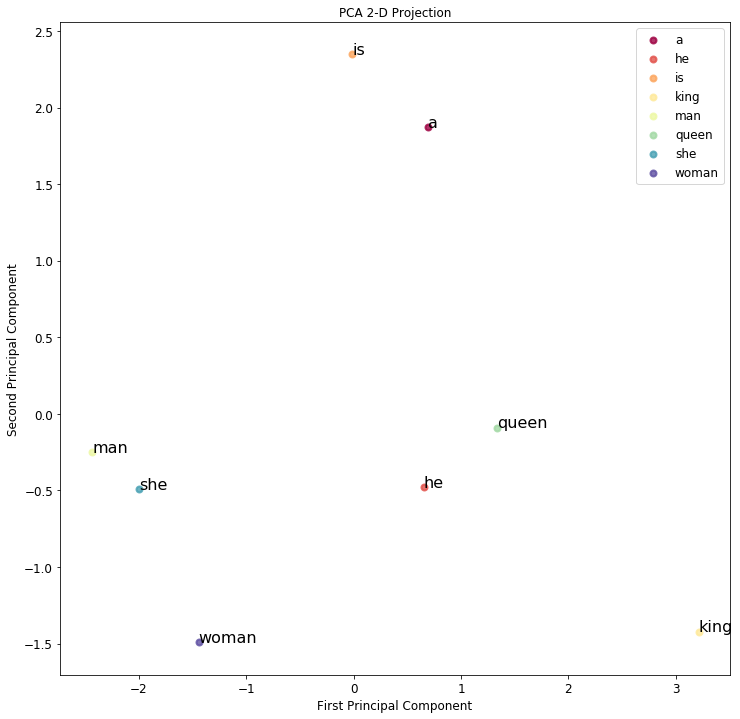

In [178]:
pca = PCA(n_components=2)
pca.fit(W1.data.numpy().T)
proj = pca.transform(W1.data.numpy().T)
ax = plot_pca_2d_projection(pca, W1.data.numpy().T, np.array(words), feature_labels=words, figsize=(12,12), text_fontsize=12) 
#ax.legend(None)
for i, txt in enumerate(words):
    ax.annotate(txt, (proj[i,0], proj[i,1]), size=16)

In [171]:
W1

tensor([[ 1.7620,  0.8666, -1.0354, -0.9067,  0.8850,  0.3915,  1.0279,  1.6976],
        [-1.8416,  0.0356,  0.6015, -2.0840,  1.5113, -0.0644,  0.3148,  0.0306],
        [ 0.9608, -0.2544,  0.5860,  2.2998,  0.5259,  2.9280, -0.3056,  0.4061],
        [-0.1829,  0.1579, -0.6038, -0.5701,  0.7641,  1.1870,  1.0767, -0.0745],
        [-0.5013,  0.2737, -0.7808,  0.6524, -1.4696, -0.3382, -1.0826,  0.0457],
        [ 0.3698, -0.9928, -0.3445,  1.2673,  0.3717,  0.3220, -1.4021, -0.4758],
        [-0.1816, -1.9853,  0.2727,  0.0325,  0.4362, -0.0631,  0.9037,  1.6224],
        [-0.0343, -0.0761,  0.2448,  0.7022, -0.0004,  0.9289,  0.2689,  0.2568],
        [ 0.1494,  0.2377,  0.7335, -1.5329, -0.4698,  0.3020, -0.2835, -0.9405],
        [ 0.9927,  0.2027, -0.4448,  0.6140,  2.5387,  0.3623,  2.4285,  2.2050]],
       requires_grad=True)

tensor([[ 0.5257,  0.2596,  0.1361,  0.0739,  0.6341, -0.8436,  0.4066, -0.7261,
          0.3830, -0.7269],
        [ 0.4310, -1.1679,  1.7933, -0.1156, -1.8036,  0.1729,  1.7555,  0.0885,
         -0.3222,  2.0131],
        [ 1.5198, -0.8258,  1.2343,  1.0623, -0.3577,  0.2151, -0.3089,  0.8005,
         -1.7971,  2.1426],
        [-0.5439, -0.9600,  0.0525,  1.2637, -0.3665, -0.7842,  0.1353, -0.4194,
         -0.6636, -0.0514],
        [ 0.1146,  1.8355,  0.2471, -0.6834,  1.2891, -0.8550, -0.0447,  1.2180,
         -1.7130, -0.3679],
        [ 0.1389, -0.1497, -1.0238,  0.7871, -0.4360,  0.7965,  0.0736, -1.1654,
          1.4173,  0.5165],
        [ 0.3160, -0.1712, -0.3858,  0.6200,  0.6054, -0.0755,  0.4947,  0.4427,
          0.9851,  0.3829],
        [ 0.6324,  0.3515, -0.0709, -0.7891,  0.0497,  0.6087, -0.1766,  0.7769,
         -0.6288,  0.1688]], requires_grad=True)

In [62]:
def get_word_vector_v(word):
    return W1[:, word2idx[word]].data.numpy()

def get_word_vector_u(word):
    return W2[word2idx[word],:].data.numpy()

In [16]:
pol = 1 * get_word_vector_v('poland') + 1 * get_word_vector_u('poland')
ger = 1 * get_word_vector_v('germany') + 1 * get_word_vector_u('germany') 
waw = 1 * get_word_vector_v('warsaw') + 1 * get_word_vector_u('warsaw') 

yyy = waw - pol + ger

KeyError: 'poland'

In [17]:
from scipy.spatial.distance import cosine
distances = [(v, cosine(yyy, 1 * get_word_vector_u(v) + 1 * get_word_vector_v(v))) for v in words]

NameError: name 'yyy' is not defined

In [18]:
# Poland to Warsaw is like Germany to Berlin

In [19]:
distances

NameError: name 'distances' is not defined

In [ ]:
# In what context Paris appears?

In [ ]:
context_to_predict = get_word_vector_v('paris')
hidden = Variable(torch.from_numpy(context_to_predict)).float()
a = torch.matmul(W2, hidden)
probs = F.softmax(a, dim=0).data.numpy()
for context, prob in zip(words, probs):
    print(f'{context}: {prob:.2f}')